# 1.NLPDemo

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

基于pytorch的网络编写
实现一个网络完成一个简单nlp任务
判断文本中是否有某些特定字符出现

In [40]:
class TorchModel(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab), vector_dim)
        self.pool = nn.AvgPool1d(sentence_length)
        self.classify = nn.Linear(vector_dim,1)
        self.activation = torch.sigmoid
        self.loss = nn.functional.mse_loss

    def forward(self, x, y=None):
        x = self.embedding(x)
        x = x.transpose(1,2)
        x = self.pool(x)
        x = x.squeeze()
        x = self.classify(x)
        y_pred = self.activation(x)
        if y is not None:
            return self.loss(y_pred,y)
        else:
            return y_pred

    

In [41]:
def build_vocab():
    chars = "abcdefghijklmnopqrstuvwxyz"
    vocab = {"pad":0}
    for index,char in enumerate(chars):
        vocab[char] = index+1
    vocab['unk'] = len(vocab)
    return vocab

In [42]:
def build_sample(vocab, sentence_length):
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    if set("abc") & set(x):
        y = 1
    else:
        y = 0
    x = [vocab.get(word, vocab['unk']) for word in x]
    return x,y

In [43]:
def build_dataset(sample_length, vocab, sentence_length):
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        dataset_y.append([y])
    return torch.LongTensor(dataset_x), torch.FloatTensor(dataset_y)

In [44]:
def build_model(vocab, char_dim, sentence_length):
    model = TorchModel(char_dim, sentence_length, vocab)
    return model

In [45]:
def evaluate(model, vocab, sample_length):
    x, y = build_dataset(200, vocab, sample_length)
    print("本次预测集中共有%d个正样本，%d个负样本"%(sum(y), 200 - sum(y)))
    correct, wrong = 0,0
    with torch.no_grad():
        y_pred = model(x)
        for y_p, y_t in zip(y_pred, y):
            if float(y_p) < 0.5 and int(y_t) ==0:
                correct += 1
            elif float(y_p) >= 0.5 and int(y_t) == 1:
                correct += 1   #正样本判断正确
            else:
                wrong += 1
    print("正确预测个数：%d, 正确率：%f"%(correct, correct/(correct+wrong)))
    return correct/(correct+wrong)

In [46]:
def main():
    #配置参数
    epoch_num = 20        #训练轮数
    batch_size = 20       #每次训练样本个数
    train_sample = 500    #每轮训练总共训练的样本总数
    char_dim = 20         #每个字的维度
    sentence_length = 6   #样本文本长度
    learning_rate = 0.005 #学习率
    # 建立字表
    vocab = build_vocab()
    # 建立模型
    model = build_model(vocab, char_dim, sentence_length)
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch in range(int(train_sample/batch_size)):
            x, y = build_dataset(batch_size, vocab, sentence_length)
            optim.zero_grad()
            loss = model(x,y)
            loss.backward()
            optim.step()
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model, vocab, sentence_length)   #测试本轮模型结果
        log.append([acc, np.mean(watch_loss)])
    #画图
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  #画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  #画loss曲线
    plt.legend()
    plt.show()
    #保存模型
    torch.save(model.state_dict(), "model.pth")
    # 保存词表
    writer = open("vocab.json", "w", encoding="utf8")
    writer.write(json.dumps(vocab, ensure_ascii=False, indent=2))
    writer.close()
    return 


In [55]:
def predict(model_path, vocab_path, input_strings):
    char_dim = 20
    sentence_length = 6
    vocab = json.load(open(vocab_path, "r", encoding="utf-8"))
    model = build_model(vocab, char_dim, sentence_length)
    model.load_state_dict(torch.load(model_path))
    x = []
    for input_string in input_strings:
        x.append([vocab[char] for char in input_string])
    model.eval()
    with torch.no_grad():
        result = model.forward(torch.LongTensor(x))
    print(result)
    for i ,input_string in enumerate(input_strings):
        print("输入：%s, 预测类别：%d, 概率值：%f" % (input_string, round(float(result[i])), result[i])) #打印结果
    

第1轮平均loss:0.229556
本次预测集中共有98个正样本，102个负样本
正确预测个数：137, 正确率：0.685000
第2轮平均loss:0.208202
本次预测集中共有108个正样本，92个负样本
正确预测个数：154, 正确率：0.770000
第3轮平均loss:0.178946
本次预测集中共有106个正样本，94个负样本
正确预测个数：168, 正确率：0.840000
第4轮平均loss:0.160649
本次预测集中共有91个正样本，109个负样本
正确预测个数：182, 正确率：0.910000
第5轮平均loss:0.129460
本次预测集中共有104个正样本，96个负样本
正确预测个数：192, 正确率：0.960000
第6轮平均loss:0.103566
本次预测集中共有113个正样本，87个负样本
正确预测个数：199, 正确率：0.995000
第7轮平均loss:0.078903
本次预测集中共有103个正样本，97个负样本
正确预测个数：200, 正确率：1.000000
第8轮平均loss:0.059274
本次预测集中共有94个正样本，106个负样本
正确预测个数：200, 正确率：1.000000
第9轮平均loss:0.042413
本次预测集中共有90个正样本，110个负样本
正确预测个数：200, 正确率：1.000000
第10轮平均loss:0.029878
本次预测集中共有104个正样本，96个负样本
正确预测个数：200, 正确率：1.000000
第11轮平均loss:0.024690
本次预测集中共有102个正样本，98个负样本
正确预测个数：200, 正确率：1.000000
第12轮平均loss:0.018346
本次预测集中共有105个正样本，95个负样本
正确预测个数：200, 正确率：1.000000
第13轮平均loss:0.013426
本次预测集中共有113个正样本，87个负样本
正确预测个数：200, 正确率：1.000000
第14轮平均loss:0.011057
本次预测集中共有90个正样本，110个负样本
正确预测个数：200, 正确率：1.000000
第15轮平均loss:0.009101
本次预测集中共有102个正样本，98个负样本
正确预测个数：200, 正确

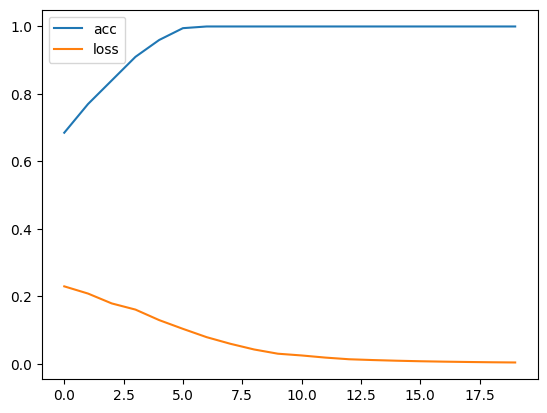

tensor([[0.0649],
        [0.0540],
        [0.0526],
        [0.9096]])
输入：fnvfee, 预测类别：0, 概率值：0.064912
输入：wzsdfg, 预测类别：0, 概率值：0.053963
输入：rqwdeg, 预测类别：0, 概率值：0.052598
输入：nakwww, 预测类别：1, 概率值：0.909606


In [56]:
if __name__ == "__main__":
    main()
    test_strings = ["fnvfee", "wzsdfg", "rqwdeg", "nakwww"]
    predict("model.pth", "vocab.json", test_strings)


# 2.Homework

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

nlpDemo改造成n分类任务，a出现在第几个位置。

换成rnn解决

In [2]:
seed = 3407
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [3]:
class TorchModel(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab_size):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vector_dim)
        self.pool = nn.AvgPool1d(sentence_length)
        self.classify = nn.Linear(vector_dim,sentence_length+1)
        self.activation = torch.sigmoid
        
    def forward(self, x):
        x = self.embedding(x)  # [bs,seq_len,emb_dim]
        x = x.transpose(1,2) # [bs,emb_dim,seq_len]
        x = self.pool(x) # [bs,emb_dim,1]
        x = x.squeeze() # [bs,emb_dim]
        x = self.classify(x) # [bs,sec_len]
        logits = self.activation(x)
        return logits

In [4]:
transformer = nn.Transformer()

In [5]:
class TorchModelWithRNN(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab_size, rnn_hidden_size=256):
        super(TorchModelWithRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vector_dim)
        self.rnn = nn.RNN(vector_dim, hidden_size=rnn_hidden_size, bias=False, batch_first=True)
        self.transformer = nn.Transformer(vector_dim)
        self.classify = nn.Linear(rnn_hidden_size,sentence_length+1)  # if argmax is sen_len, 'a' not exists
        self.activation = torch.sigmoid
        
    def forward(self, x):
        x_emb = self.embedding(x)  # [bs,seq_len,emb_dim]
        output, hidden = self.rnn(x_emb)
        x1 = self.classify(hidden)
        logits = self.activation(x1) # [bs,seq_len]
        logits = logits.squeeze(0)
        return logits 

Model Test

In [6]:
x = torch.ones((13,20))
x = x.long()
model1 = TorchModelWithRNN(512,20,100)
logits = model1(x)
logits.shape

torch.Size([13, 21])

In [7]:
def build_vocab():
    chars = "abcdefghijklmnopqrstuvwxyz"
    vocab = {"pad":0}
    for index,char in enumerate(chars):
        vocab[char] = index+1
    vocab['unk'] = len(vocab)
    return vocab

In [8]:
def build_sample(vocab, sentence_length):
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    y = x.index('a') if 'a' in x else len(x)  # if 'a' in the sentence, the first index, else len(sen)
    x = [vocab.get(word, vocab['unk']) for word in x]
    return x,y

In [9]:
vocab = build_vocab()

In [10]:
for i in range(10):
    x,y = build_sample(vocab, 10)
    print(x, y)

[1, 13, 4, 10, 6, 12, 9, 18, 27, 11] 0
[7, 24, 27, 15, 22, 16, 13, 21, 8, 27] 10
[8, 7, 3, 9, 27, 6, 10, 18, 23, 3] 10
[3, 18, 20, 7, 10, 0, 3, 8, 26, 17] 10
[1, 0, 23, 5, 25, 26, 18, 7, 15, 17] 0
[27, 9, 17, 4, 6, 15, 18, 23, 18, 18] 10
[14, 21, 0, 12, 15, 8, 20, 23, 10, 2] 10
[7, 13, 3, 27, 26, 0, 2, 21, 1, 9] 8
[5, 5, 19, 7, 24, 8, 16, 0, 3, 18] 10
[24, 0, 0, 2, 15, 5, 6, 10, 13, 4] 10


In [11]:
def build_dataset(sample_length, vocab, sentence_length):
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        dataset_y.append(y)
    return list(zip(torch.LongTensor(dataset_x), torch.LongTensor(dataset_y)))

HyperParameter

In [12]:
sentence_length = 20
trainSet_size = 50000
testSet_size = 10000
embedding_dim = 512
learning_rate = 0.005 #学习率
# device = "cuda:0"
device = 'cuda:0'
epoch_num = 200
batch_size = 256
vocab_size = len(vocab)
loss_fn = nn.CrossEntropyLoss()

In [13]:
train_dataset = build_dataset(trainSet_size, vocab, sentence_length)
test_dataset = build_dataset(testSet_size,vocab,sentence_length)

In [14]:
for data in train_dataset:
    print(data)
    break

(tensor([19, 26, 18,  5, 23, 11,  2, 23, 26,  3,  3, 12, 25, 15,  2,  0,  3, 12,
        15, 25]), tensor(20))


In [15]:
def build_model(type, vocab, embedding_dim, sentence_length):
    if type == 'type1':
        model = TorchModel(embedding_dim, sentence_length, vocab)
    elif type == 'rnn':
        model = TorchModelWithRNN(embedding_dim, sentence_length, vocab)
    return model

In [16]:
model = build_model('type1',vocab_size, embedding_dim, sentence_length)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def evaluate(model, testSet, device):
    correct, total = 0,0
    with torch.no_grad():
        for batch_idx in range(testSet_size // batch_size):
            batch_input = testSet[batch_idx * batch_size: (batch_idx+1) * batch_size]
            x = torch.stack([sample[0] for sample in batch_input]).to(device)
            y = torch.stack([sample[1] for sample in batch_input]).to(device)
            logits = model(x)
            y_pred = logits.argmax(-1)
            correct += torch.sum(y_pred.eq(y))
            total += x.shape[0]
    print("正确预测个数：%d, 正确率：%f"%(correct, correct/total))
    top1 = (correct/total).detach().cpu().numpy()
    return top1

In [18]:
def main():
    log = []
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        acc = evaluate(model, test_dataset, device)   #测试本轮模型结果
        for batch_idx in range(trainSet_size // batch_size):
            batch_input = train_dataset[batch_idx * batch_size: (batch_idx+1) * batch_size]
            x = torch.stack([sample[0] for sample in batch_input]).to(device)
            y = torch.stack([sample[1] for sample in batch_input]).to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            watch_loss.append(loss.detach().cpu().numpy())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        log.append([acc, np.mean(watch_loss)])
    #画图
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  #画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  #画loss曲线
    plt.legend()
    plt.show()
    #保存模型
    torch.save(model.state_dict(), "model.pth")
    # 保存词表
    writer = open("vocab.json", "w", encoding="utf8")
    writer.write(json.dumps(vocab, ensure_ascii=False, indent=2))
    writer.close()
    return 


正确预测个数：485, 正确率：0.048578
第1轮平均loss:2.624076
正确预测个数：4834, 正确率：0.484175
第2轮平均loss:2.592550
正确预测个数：5145, 正确率：0.515325
第3轮平均loss:2.567425
正确预测个数：5146, 正确率：0.515425
第4轮平均loss:2.566468
正确预测个数：5153, 正确率：0.516126
第5轮平均loss:2.566027
正确预测个数：5151, 正确率：0.515925
第6轮平均loss:2.565696
正确预测个数：5170, 正确率：0.517829
第7轮平均loss:2.565466
正确预测个数：5165, 正确率：0.517328
第8轮平均loss:2.565272
正确预测个数：5172, 正确率：0.518029
第9轮平均loss:2.565079
正确预测个数：5167, 正确率：0.517528
第10轮平均loss:2.564907
正确预测个数：5164, 正确率：0.517228
第11轮平均loss:2.564754
正确预测个数：5157, 正确率：0.516526
第12轮平均loss:2.564597
正确预测个数：5146, 正确率：0.515425
第13轮平均loss:2.564449
正确预测个数：5145, 正确率：0.515325
第14轮平均loss:2.564314
正确预测个数：5141, 正确率：0.514924
第15轮平均loss:2.564183
正确预测个数：5139, 正确率：0.514724
第16轮平均loss:2.564040
正确预测个数：5135, 正确率：0.514323
第17轮平均loss:2.563907
正确预测个数：5140, 正确率：0.514824
第18轮平均loss:2.563790
正确预测个数：5138, 正确率：0.514623
第19轮平均loss:2.563677
正确预测个数：5134, 正确率：0.514223
第20轮平均loss:2.563521
正确预测个数：5137, 正确率：0.514523
第21轮平均loss:2.563386
正确预测个数：5133, 正确率：0.514123
第22轮平均loss:2.56326

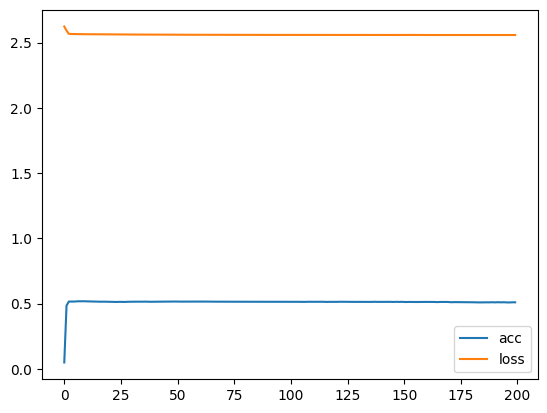

In [19]:
# 不使用rnn
main()

Statement : 不适用rnn，只加一层平均池化，准确率只有0.516627左右

In [20]:
model = build_model('rnn',vocab_size, embedding_dim, sentence_length)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

正确预测个数：342, 正确率：0.034255
第1轮平均loss:2.600123
正确预测个数：5363, 正确率：0.537159
第2轮平均loss:2.583849
正确预测个数：5363, 正确率：0.537159
第3轮平均loss:2.583564
正确预测个数：5364, 正确率：0.537260
第4轮平均loss:2.571141
正确预测个数：4792, 正确率：0.479968
第5轮平均loss:2.570289
正确预测个数：5614, 正确率：0.562300
第6轮平均loss:2.541690
正确预测个数：5827, 正确率：0.583634
第7轮平均loss:2.500853
正确预测个数：5976, 正确率：0.598558
第8轮平均loss:2.486375
正确预测个数：6083, 正确率：0.609275
第9轮平均loss:2.488691
正确预测个数：6095, 正确率：0.610477
第10轮平均loss:2.485008
正确预测个数：6197, 正确率：0.620693
第11轮平均loss:2.478490
正确预测个数：6310, 正确率：0.632011
第12轮平均loss:2.466719
正确预测个数：6341, 正确率：0.635116
第13轮平均loss:2.461567
正确预测个数：6403, 正确率：0.641326
第14轮平均loss:2.453559
正确预测个数：6629, 正确率：0.663962
第15轮平均loss:2.448647
正确预测个数：6619, 正确率：0.662961
第16轮平均loss:2.444783
正确预测个数：6642, 正确率：0.665264
第17轮平均loss:2.444038
正确预测个数：6575, 正确率：0.658554
第18轮平均loss:2.442267
正确预测个数：6588, 正确率：0.659856
第19轮平均loss:2.435417
正确预测个数：6530, 正确率：0.654046
第20轮平均loss:2.439727
正确预测个数：6594, 正确率：0.660457
第21轮平均loss:2.449082
正确预测个数：6363, 正确率：0.637320
第22轮平均loss:2.43944

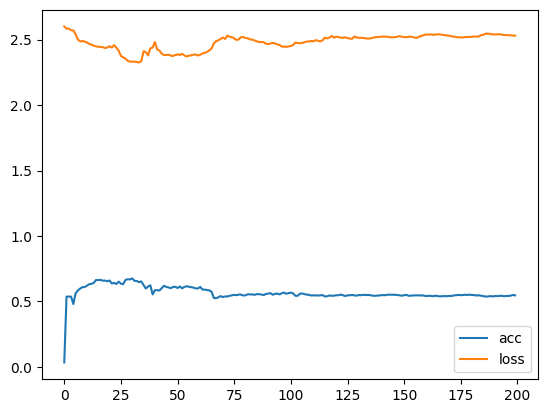

In [21]:
main()

In [ ]:
def predict(model_path, vocab_path, input_strings):
    char_dim = 20
    sentence_length = 6
    vocab = json.load(open(vocab_path, "r", encoding="utf-8"))
    model = build_model(vocab, char_dim, sentence_length)
    model.load_state_dict(torch.load(model_path))
    x = []
    for input_string in input_strings:
        x.append([vocab[char] for char in input_string])
    model.eval()
    with torch.no_grad():
        result = model.forward(torch.LongTensor(x))
    print(result)
    for i ,input_string in enumerate(input_strings):
        print("输入：%s, 预测类别：%d, 概率值：%f" % (input_string, round(float(result[i])), result[i])) #打印结果
    